In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
import wandb
from wandb.keras import WandbCallback

c:\Users\Enzo\Documents\GitHub\wssv-recognition\.conda\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: renzo_querol. Use `wandb login --relogin` to force relogin


True

In [20]:
DATA_DIR = pathlib.Path("augmented_dataset")
AUTOTUNE = tf.data.AUTOTUNE

CONFIG = dict(
    epochs=400,
    learning_rate=1e-6,
    batch_size=32,
    img_shape=(224, 224),
    input_shape=(224, 224, 3),
    num_classes=2,
    dropout_rate=0.4,
    es_patience=40,
    valid_split=0.4,
    seed_value=42,
)

wandb.init(
    project="wssv-recognition",
    config=CONFIG,
    group="MobileNetV3Small",
    job_type="train",
)

In [21]:
image_count = len(list(DATA_DIR.glob("*/*.jpg")))
healthy_count = len(list(DATA_DIR.glob("healthy/*.jpg")))
wssv_count = len(list(DATA_DIR.glob("wssv/*.jpg")))

print(f"Total number of images: {image_count}")
print(f"Healthy: {healthy_count}")
print(f"WSSV: {wssv_count}\n")

train_set, valid_set = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=CONFIG["valid_split"],
    seed=CONFIG["seed_value"],
    image_size=CONFIG["img_shape"],
    batch_size=CONFIG["batch_size"],
    interpolation="bicubic",
    label_mode="binary",
    subset="both",
)

class_names = train_set.class_names
print(f"\nClass names: {class_names}")

Total number of images: 930
Healthy: 702
WSSV: 228



KeyError: 'img_height'

In [17]:
validation_batches = tf.data.experimental.cardinality(valid_set)
test_dataset = valid_set.take(validation_batches // 5)
validation_dataset = valid_set.skip(validation_batches // 5)

train_dataset = train_set.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(
    f"\nNumber of training batches: {tf.data.experimental.cardinality(train_dataset)}"
)
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


Number of training batches: 18
Number of validation batches: 10
Number of test batches: 2


In [18]:
"""
DEFINE BASE MODEL HERE
"""
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(CONFIG["img_height"], CONFIG["img_width"], 3),
    include_top=False,
)

"""
CREATE MODEL HERE
"""
inputs = tf.keras.Input(shape=(CONFIG["img_height"], CONFIG["img_width"], 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(x)
outputs = tf.keras.layers.Dense(units=2)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="acc"),
        tf.keras.metrics.Precision(thresholds=0, name="prec"),
        tf.keras.metrics.Recall(thresholds=0, name="recall"),
        tfa.metrics.F1Score(
            num_classes=2, average="weighted", name="f1_score", threshold=0.5
        ),
        tf.keras.metrics.FalseNegatives(name="false_neg"),
    ],
)

In [19]:
class_0_weight = (1 / healthy_count) * (image_count / 2.0)
class_1_weight = (1 / wssv_count) * (image_count / 2.0)
class_weight = {0: class_0_weight, 1: class_1_weight}

history = model.fit(
    train_dataset,
    epochs=CONFIG["epochs"],
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=CONFIG["es_patience"]),
        WandbCallback(save_model=False),
    ],
)

Error: You must call wandb.init() before WandbCallback()

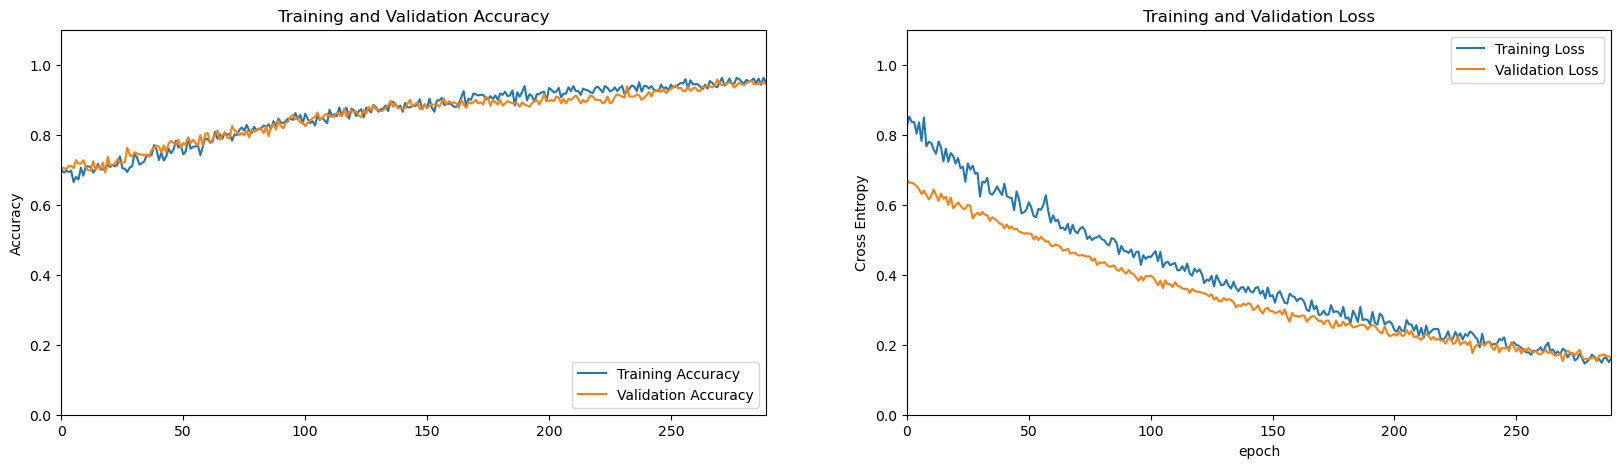

In [9]:
acc = history.history["acc"]
val_acc = history.history["val_acc"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

prec = history.history["precision"]
val_prec = history.history["val_prec"]

recall = history.history["recall"]
val_recall = history.history["val_recall"]

f1_score = history.history["f1_score"]
val_f1_score = history.history["val_f1_score"]

false_neg = history.history["false_neg"]
val_false_neg = history.history["val_false_neg"]


plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

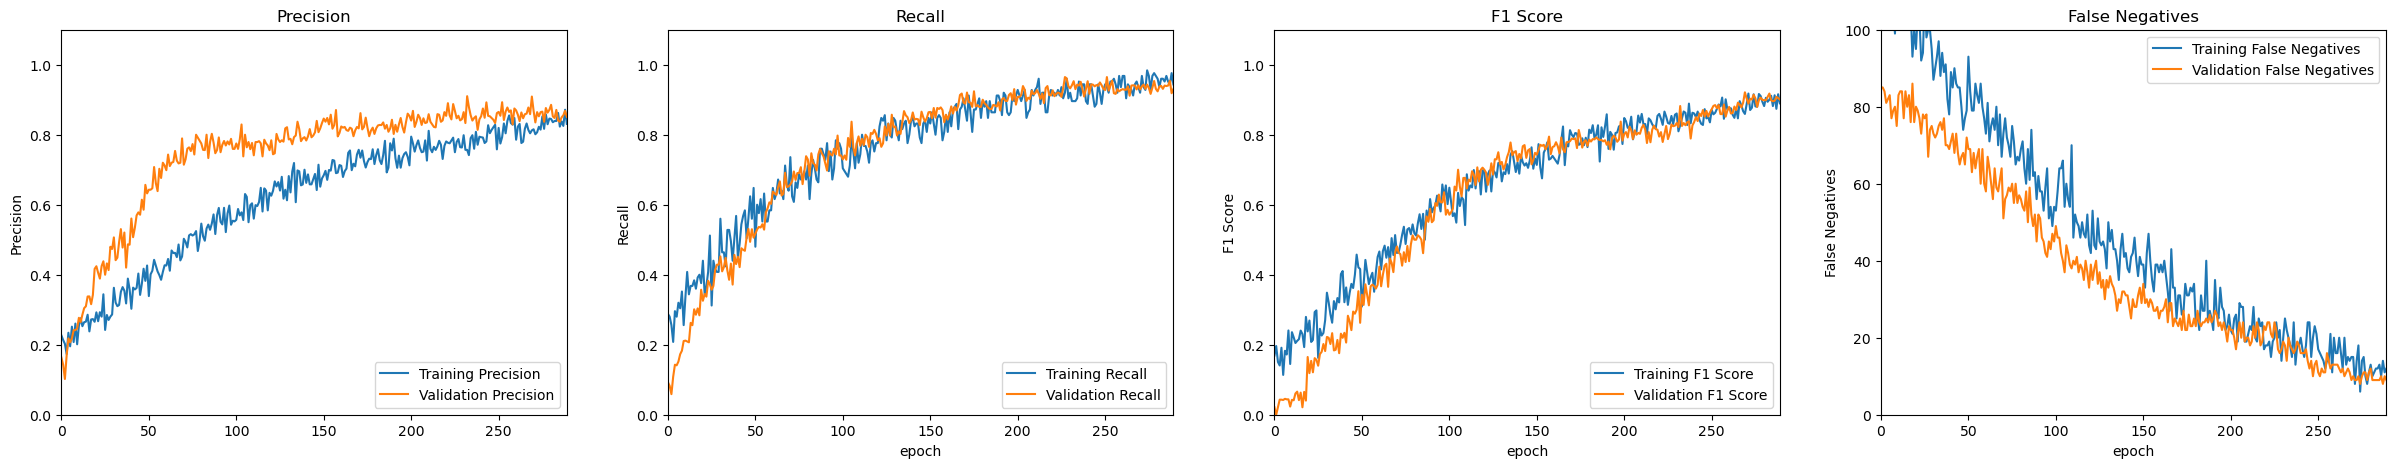

In [10]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 4, 1)
plt.plot(prec, label="Training Precision")
plt.plot(val_prec, label="Validation Precision")
plt.legend(loc="lower right")
plt.ylabel("Precision")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Precision")

plt.subplot(1, 4, 2)
plt.plot(recall, label="Training Recall")
plt.plot(val_recall, label="Validation Recall")
plt.legend(loc="lower right")
plt.ylabel("Recall")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Recall")
plt.xlabel("epoch")

plt.subplot(1, 4, 3)
plt.plot(f1_score, label="Training F1 Score")
plt.plot(val_f1_score, label="Validation F1 Score")
plt.legend(loc="lower right")
plt.ylabel("F1 Score")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("F1 Score")
plt.xlabel("epoch")

plt.subplot(1, 4, 4)
plt.plot(fns, label="Training False Negatives")
plt.plot(val_fns, label="Validation False Negatives")
plt.legend(loc="upper right")
plt.ylabel("False Negatives")
plt.ylim([0, 100])
plt.xlim([0, history.epoch[-1]])
plt.title("False Negatives")
plt.xlabel("epoch")

plt.show()

In [11]:
wandb.finish()

accuracy,▂▁▂▂▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▆▆▇▇▇▆▆▇▇▇▇▇▇▇█▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
f1_score,▁▁▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▇█▇███
fn,██▇▇▇▆▆▆▆▅▆▅▅▅▅▄▃▃▄▃▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▁▂▁▁▁
loss,██▇▇▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁
precision,▁▁▂▂▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇███
recall,▁▂▃▃▃▄▄▅▄▆▅▆▆▆▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇████▇██████
val_accuracy,▁▁▁▂▂▃▂▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇█▇████
val_f1_score,▁▁▁▂▂▂▃▃▄▄▄▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
val_fn,███▇▇▇▇▇▆▆▆▆▅▄▄▄▃▄▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▁▂▁▁▁▁
val_loss,██▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
